In [1]:
import numpy as np
from scipy.spatial import KDTree
import os
import h5py
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from tqdm import tqdm

In [2]:
gmet_root_dir = r'C:\Users\c.kwa\Desktop\meteosat_retrieval\data_downloads\GMET\GMet_AWSdata\GMet_AWSdata'
# File path TAHMO station data (CSV format with columns:'Precipitation (mm)')
tahmo_root_dir = r'C:\Users\c.kwa\Desktop\meteosat_retrieval\data_downloads\TAHMO\TAHMO_export_6704eaa37e81da18c0b7e245'

In [3]:
station_data_list_GMET = []
station_name_list_files = []
for station in os.listdir(gmet_root_dir):
    if station.endswith('.csv'):
        station_file = os.path.join(gmet_root_dir, station)
        station_data = pd.read_csv(station_file)
        station_data_list_GMET.append(station_data)
        station_name_list_files.append(station.split('.')[0])
        #display(station_data)

stations_meta_data_GMET = station_data_list_GMET.pop(7)
station_name_list = stations_meta_data_GMET['STN'].tolist()

station_data_gmet_dict = dict(zip(station_name_list, station_data_list_GMET))

for station_name in station_data_gmet_dict:
    # Convert 'timestamp' column to datetime format
    station_data_gmet_dict[station_name]['Timestamp'] = pd.to_datetime(
        station_data_gmet_dict[station_name]['Date'].astype(str) + ' ' + 
        station_data_gmet_dict[station_name]['Time'].astype(str),
        format='%m/%d/%Y %I:%M:%S %p'
    )
    # Set Timestamp as the index
    station_data_gmet_dict[station_name] = station_data_gmet_dict[station_name].set_index('Timestamp')
    # Drop the original Date and Time columns
    station_data_gmet_dict[station_name] = station_data_gmet_dict[station_name].drop(['Date', 'Time'], axis=1)

    # Ensure the column is numeric
    for col in station_data_gmet_dict[station_name].columns:
        station_data_gmet_dict[station_name][col] = pd.to_numeric(station_data_gmet_dict[station_name][col], errors='coerce')

        # Accumulate over 30 minutes
        station_data_gmet_dict[station_name] = station_data_gmet_dict[station_name].resample('30min', label = 'right', closed = 'right').sum(min_count = 2)

In [4]:
station_name_list_tahmo = []
station_data_list_TAHMO = []
for station in os.listdir(tahmo_root_dir): 
    if station.endswith('.csv'):
        station_file = os.path.join(tahmo_root_dir, station)
        station_data = pd.read_csv(station_file)
        station_name_list_tahmo.append(station.split('.')[0])
        station_data_list_TAHMO.append(station_data)

sensors_meta_data_tahmo = station_data_list_TAHMO.pop(0)
stations_meta_data_tahmo = station_data_list_TAHMO.pop(0)
sensors_meta_data_tahmo_name = station_name_list_tahmo.pop(0)
stations_meta_data_tahmo_name = station_name_list_tahmo.pop(0)


station_data_tahmo_dict = dict(zip(station_name_list_tahmo, station_data_list_TAHMO))

#Assuming df is the DataFrame containing the data
for station_name in station_data_tahmo_dict:
    if station_data_tahmo_dict[station_name].shape[1] == 3:
        station_data_tahmo_dict[station_name]['precipitation (mm)'] = station_data_tahmo_dict[station_name].iloc[:, 2].combine_first(station_data_tahmo_dict[station_name].iloc[:, 2])

        # Dropping the old columns (optional)
        station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].drop(station_data_tahmo_dict[station_name].columns[[1, 2]], axis = 1)

        # # Result
        # display(station_data_tahmo_dict[station_name].head())

    elif station_data_tahmo_dict[station_name].shape[1] == 4:
        station_data_tahmo_dict[station_name]['precipitation (mm)'] = station_data_tahmo_dict[station_name].iloc[:, 2].combine_first(station_data_tahmo_dict[station_name].iloc[:, 1]).combine_first(station_data_tahmo_dict[station_name].iloc[:, 3])
        # Dropping the old columns (optional)
        station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].drop(station_data_tahmo_dict[station_name].columns[[1, 2, 3]], axis = 1)


    if 'timestamp' in station_data_tahmo_dict[station_name].columns:
        # Set Timestamp as the index
        station_data_tahmo_dict[station_name]['timestamp'] = pd.to_datetime(station_data_tahmo_dict[station_name]['timestamp'])
        station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].set_index('timestamp')

    # Accumulate over 30 minutes
    station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].resample('30min').sum(min_count = 2)


In [5]:
df_pred = pd.read_csv('df_output_MSE_gmet_2022.csv', index_col = 0, parse_dates = True)
df_pred[df_pred <= 0.02] = 0
df_pred_balanced = pd.read_csv('df_output_balanced_gmet_2022.csv', index_col = 0, parse_dates = True)
df_pred_balanced[df_pred_balanced <= 0.02] = 0
df_target = pd.read_csv('df_imerg_final_gmet.csv', index_col = 0, parse_dates = True)
df_target = df_target.loc['2022']

# df_target = pd.read_csv('df_target_MSE_gmet_2022.csv', index_col = 0, parse_dates = True)
# df_target[df_target <= 0.02] = 0

df_early = pd.read_csv('df_imerg_early_gmet.csv', index_col = 0, parse_dates = True)

In [6]:
df_pred_tahmo = pd.read_csv('df_output_MSE_tahmo_2022.csv', index_col = 0, parse_dates = True)
df_pred_tahmo[df_pred_tahmo <= 0.02] = 0
df_pred_balanced_tahmo = pd.read_csv('df_output_balanced_tahmo_2022.csv', index_col = 0, parse_dates = True)
df_pred_balanced_tahmo[df_pred_balanced_tahmo <= 0.02] = 0
df_target_tahmo = pd.read_csv('df_imerg_final_tahmo.csv', index_col = 0, parse_dates = True)
df_target_tahmo = df_target_tahmo.loc['2022']

# df_target_tahmo = pd.read_csv('df_target_MSE_tahmo_2022.csv', index_col = 0, parse_dates = True)
# df_target_tahmo[df_target_tahmo <= 0.02] = 0

df_early_tahmo = pd.read_csv('df_imerg_early_tahmo.csv', index_col = 0, parse_dates = True)

In [32]:
for station in station_data_gmet_dict:
    # print(station)
    filtered_df = filtered_data = station_data_gmet_dict[station][station_data_gmet_dict[station]['Precipitation (mm)'] >= 0.1]
    print(f'{station} = {filtered_df.quantile(0.99)}')

Abetifi = Precipitation (mm)    19.0
Name: 0.99, dtype: float64
Ada_Foah = Precipitation (mm)    18.008
Name: 0.99, dtype: float64
Akim_Oda = Precipitation (mm)    23.6
Name: 0.99, dtype: float64
Akosombo = Precipitation (mm)    20.412
Name: 0.99, dtype: float64
Akuse = Precipitation (mm)    22.838
Name: 0.99, dtype: float64
Axim = Precipitation (mm)    26.22
Name: 0.99, dtype: float64
Enchi = Precipitation (mm)    17.0
Name: 0.99, dtype: float64
Jirapa = Precipitation (mm)    15.496
Name: 0.99, dtype: float64
Kalbeo = Precipitation (mm)    24.01
Name: 0.99, dtype: float64
Kpandai = Precipitation (mm)    19.0
Name: 0.99, dtype: float64
Loagri = Precipitation (mm)    16.62
Name: 0.99, dtype: float64
Nakpamboni = Precipitation (mm)    22.462
Name: 0.99, dtype: float64
Sefwi_Bekwai = Precipitation (mm)    19.6
Name: 0.99, dtype: float64
Tarkwa = Precipitation (mm)    52.36
Name: 0.99, dtype: float64
Tema = Precipitation (mm)    21.408
Name: 0.99, dtype: float64
Tolon = Precipitation (mm) 

In [41]:
for station in station_data_gmet_dict:
    df = station_data_gmet_dict[station].resample('D').sum(min_count = 48)
    filtered_df = df[df['Precipitation (mm)'] >= 0.1]
    station_data_gmet_dict[station][station_data_gmet_dict[station]['Precipitation (mm)'] >= 0.1]
    print(f'{station} = {filtered_df.quantile(0.99)}')

Abetifi = Precipitation (mm)    56.2
Name: 0.99, dtype: float64
Ada_Foah = Precipitation (mm)    46.87
Name: 0.99, dtype: float64
Akim_Oda = Precipitation (mm)    66.69
Name: 0.99, dtype: float64
Akosombo = Precipitation (mm)    60.836
Name: 0.99, dtype: float64
Akuse = Precipitation (mm)    68.76
Name: 0.99, dtype: float64
Axim = Precipitation (mm)    108.272
Name: 0.99, dtype: float64
Enchi = Precipitation (mm)    46.952
Name: 0.99, dtype: float64
Jirapa = Precipitation (mm)    37.598
Name: 0.99, dtype: float64
Kalbeo = Precipitation (mm)    53.28
Name: 0.99, dtype: float64
Kpandai = Precipitation (mm)    47.602
Name: 0.99, dtype: float64
Loagri = Precipitation (mm)    41.88
Name: 0.99, dtype: float64
Nakpamboni = Precipitation (mm)    70.536
Name: 0.99, dtype: float64
Sefwi_Bekwai = Precipitation (mm)    53.432
Name: 0.99, dtype: float64
Tarkwa = Precipitation (mm)    165.518
Name: 0.99, dtype: float64
Tema = Precipitation (mm)    58.408
Name: 0.99, dtype: float64
Tolon = Precipitat

In [33]:
for station in station_data_tahmo_dict:
    # print(station)
    filtered_df = filtered_data = station_data_tahmo_dict[station][station_data_tahmo_dict[station]['precipitation (mm)'] >= 0.1]
    print(f'{station} = {filtered_df.quantile(0.99)}')

TA00005 = precipitation (mm)    23.0291
Name: 0.99, dtype: float64
TA00007 = precipitation (mm)    23.77712
Name: 0.99, dtype: float64
TA00010 = precipitation (mm)    24.364
Name: 0.99, dtype: float64
TA00016 = precipitation (mm)    28.78386
Name: 0.99, dtype: float64
TA00045 = precipitation (mm)    30.26655
Name: 0.99, dtype: float64
TA00113 = precipitation (mm)    22.42772
Name: 0.99, dtype: float64
TA00116 = precipitation (mm)    24.59404
Name: 0.99, dtype: float64
TA00117 = precipitation (mm)    26.0792
Name: 0.99, dtype: float64
TA00118 = precipitation (mm)    23.26352
Name: 0.99, dtype: float64
TA00120 = precipitation (mm)    21.44031
Name: 0.99, dtype: float64
TA00121 = precipitation (mm)    19.4268
Name: 0.99, dtype: float64
TA00136 = precipitation (mm)    31.60675
Name: 0.99, dtype: float64
TA00251 = precipitation (mm)    31.96141
Name: 0.99, dtype: float64
TA00254 = precipitation (mm)    22.65359
Name: 0.99, dtype: float64
TA00259 = precipitation (mm)    22.51598
Name: 0.99, 

In [47]:
for station in station_data_tahmo_dict:
    df = station_data_tahmo_dict[station].resample('D').sum(min_count = 48)
    filtered_df = df[df['precipitation (mm)'] >= 0.1]
    print(f'{station} = {filtered_df.quantile(0.99)}')

TA00005 = precipitation (mm)    56.0142
Name: 0.99, dtype: float64
TA00007 = precipitation (mm)    54.19956
Name: 0.99, dtype: float64
TA00010 = precipitation (mm)    58.2618
Name: 0.99, dtype: float64
TA00016 = precipitation (mm)    84.72287
Name: 0.99, dtype: float64
TA00045 = precipitation (mm)    71.66942
Name: 0.99, dtype: float64
TA00113 = precipitation (mm)    67.75874
Name: 0.99, dtype: float64
TA00116 = precipitation (mm)    70.61416
Name: 0.99, dtype: float64
TA00117 = precipitation (mm)    68.92488
Name: 0.99, dtype: float64
TA00118 = precipitation (mm)    56.46208
Name: 0.99, dtype: float64
TA00120 = precipitation (mm)    107.8958
Name: 0.99, dtype: float64
TA00121 = precipitation (mm)    90.91467
Name: 0.99, dtype: float64
TA00136 = precipitation (mm)    93.51616
Name: 0.99, dtype: float64
TA00251 = precipitation (mm)    76.02476
Name: 0.99, dtype: float64
TA00254 = precipitation (mm)    62.75216
Name: 0.99, dtype: float64
TA00259 = precipitation (mm)    52.60378
Name: 0.9

In [8]:
for station in station_data_gmet_dict:
    print(station)
    # Assuming each station's data is a DataFrame with a column named 'precipitation'
    filtered_data = df_pred_balanced[df_pred_balanced[station] >= 8]
    if '2022' in filtered_data.index:
        display(filtered_data[station].loc['2022'])

Abetifi


2022-04-21 10:30:00    8.348843
2022-04-21 11:00:00    8.181581
Name: Abetifi, dtype: float64

Ada_Foah


2022-10-25 15:00:00    10.454000
2022-10-25 15:30:00     9.511891
Name: Ada_Foah, dtype: float64

Akim_Oda


2022-09-28 16:30:00    8.035719
2022-09-28 17:00:00    8.424274
2022-09-28 17:30:00    8.772243
2022-09-28 18:00:00    9.012170
Name: Akim_Oda, dtype: float64

Akosombo


2022-04-03 23:00:00     8.693695
2022-04-24 15:00:00    10.084573
2022-06-29 18:00:00     9.994274
2022-06-29 18:30:00     9.175756
2022-09-28 16:30:00     9.321329
2022-09-28 17:00:00    10.221553
2022-09-28 17:30:00     9.405547
Name: Akosombo, dtype: float64

Akuse


2022-06-29 19:00:00     8.311379
2022-09-28 16:30:00    10.152832
2022-09-28 17:00:00    12.181163
2022-09-28 17:30:00    11.058509
2022-10-25 15:30:00     8.713266
2022-12-03 00:30:00     9.772049
Name: Akuse, dtype: float64

Axim


2022-04-24 17:00:00    11.937123
2022-04-24 17:30:00    18.054571
2022-04-24 18:00:00    15.184198
2022-04-24 18:30:00    16.613243
2022-04-24 19:00:00    12.712865
2022-05-06 15:00:00     8.348843
2022-10-25 20:30:00     8.596498
2022-10-25 21:00:00    11.593229
2022-10-29 00:00:00    10.337124
2022-10-29 00:30:00    13.357581
2022-11-10 16:30:00    13.327579
2022-11-10 17:00:00    13.417788
Name: Axim, dtype: float64

Enchi


2022-04-14 19:00:00     9.073171
2022-04-14 19:30:00    10.477533
2022-04-14 20:00:00     8.772243
2022-09-15 19:00:00    10.337124
2022-09-15 19:30:00     8.851500
2022-11-02 21:30:00     8.163204
Name: Enchi, dtype: float64

Jirapa


2022-06-20 22:00:00     9.426721
2022-06-20 22:30:00     8.615850
2022-07-23 05:30:00     8.311379
2022-07-23 06:00:00    12.972764
2022-07-23 06:30:00    14.161799
2022-07-23 07:00:00    11.108353
2022-07-26 10:30:00     8.971732
2022-07-26 11:00:00     8.596498
2022-07-31 17:00:00     8.577189
2022-07-31 17:30:00     8.405353
2022-08-08 15:00:00     9.684548
2022-08-08 15:30:00    10.477533
2022-09-05 01:30:00     8.951580
2022-09-05 02:00:00     9.196412
2022-09-05 18:00:00    10.244564
2022-09-08 17:30:00     8.772243
2022-10-04 21:30:00    10.836961
2022-10-04 22:00:00     9.772049
Name: Jirapa, dtype: float64

Kalbeo


2022-04-07 20:00:00     8.236959
2022-07-08 19:00:00     9.052791
2022-07-08 19:30:00    11.463614
2022-07-23 00:00:00     8.615850
2022-07-23 00:30:00     8.255502
2022-09-18 15:30:00     8.654684
2022-09-18 16:00:00     8.811783
2022-09-18 16:30:00     8.811783
2022-09-30 10:30:00     8.108320
Name: Kalbeo, dtype: float64

Kpandai


2022-04-16 01:30:00    8.163204
2022-04-16 02:00:00    9.155147
2022-04-16 02:30:00    9.684548
2022-06-29 17:30:00    9.052791
2022-06-29 18:00:00    8.615850
2022-08-19 07:30:00    9.175756
Name: Kpandai, dtype: float64

Loagri


2022-05-30 23:30:00     9.490526
2022-06-14 03:00:00     8.654684
2022-07-23 00:30:00    11.233950
2022-07-23 01:00:00    15.494619
2022-07-23 01:30:00    14.713635
2022-07-23 02:00:00    11.619327
2022-07-23 02:30:00     8.654684
Name: Loagri, dtype: float64

Nakpamboni


2022-04-06 04:00:00     8.772243
2022-04-06 04:30:00     8.772243
2022-06-29 16:00:00     8.693695
2022-06-29 16:30:00     9.662796
2022-07-23 00:00:00     9.114066
2022-07-23 00:30:00    12.570734
2022-07-23 01:00:00    10.360394
2022-07-23 01:30:00     9.052791
2022-07-23 02:00:00     9.196412
2022-07-23 02:30:00     9.196412
2022-08-19 06:30:00    11.183541
2022-08-22 23:30:00     8.348843
2022-08-23 00:00:00     8.424274
2022-09-18 16:00:00    12.486218
2022-09-18 16:30:00    12.486218
Name: Nakpamboni, dtype: float64

Sefwi_Bekwai


2022-04-04 07:00:00    8.674169
2022-07-01 18:00:00    8.911412
2022-07-01 18:30:00    8.071938
Name: Sefwi_Bekwai, dtype: float64

Tarkwa


2022-04-21 15:00:00    12.827727
2022-04-21 15:30:00    11.830236
2022-04-21 16:00:00     8.053807
2022-04-24 15:30:00     8.017670
2022-05-09 15:30:00    10.812619
2022-06-10 13:30:00     8.424274
2022-06-10 14:00:00     8.911412
2022-06-10 14:30:00     8.071938
Name: Tarkwa, dtype: float64

Tema


2022-05-06 11:00:00     9.342313
2022-05-06 11:30:00     9.554765
2022-06-10 11:00:00     8.577189
2022-06-15 10:30:00     8.311379
2022-10-25 15:30:00     8.732880
2022-10-25 16:00:00    11.008888
Name: Tema, dtype: float64

Tolon


Series([], Name: Tolon, dtype: float64)

Varenpare


2022-07-08 17:00:00     8.596498
2022-07-23 02:30:00     8.424274
2022-07-23 03:00:00     8.971732
2022-07-31 16:30:00     9.237864
2022-08-13 00:30:00     9.882537
2022-08-13 01:00:00    12.770166
2022-08-13 01:30:00    13.417788
2022-08-13 02:00:00    13.692099
2022-08-13 02:30:00    12.263614
2022-08-13 03:00:00    10.477533
2022-09-18 20:00:00     9.093595
2022-09-18 20:30:00     9.971826
2022-09-18 21:00:00    12.684311
2022-09-18 21:30:00    10.244564
2022-09-26 09:00:00     8.971732
2022-09-26 09:30:00     8.500388
Name: Varenpare, dtype: float64

Yendi


2022-07-23 00:30:00    12.153803
2022-07-23 01:00:00    13.539019
2022-07-23 01:30:00    12.570734
2022-07-23 02:00:00    12.263614
2022-07-23 02:30:00    12.263614
2022-08-19 06:30:00     8.732880
2022-08-23 00:00:00     9.073171
2022-08-23 00:30:00     8.199999
2022-08-23 02:00:00     8.330090
2022-08-23 02:30:00     8.615850
2022-09-15 10:30:00     8.348843
Name: Yendi, dtype: float64

In [24]:
for station in station_data_gmet_dict:
    print(station)
    # Assuming each station's data is a DataFrame with a column named 'precipitation'
    filtered_data = station_data_gmet_dict[station][station_data_gmet_dict[station]['Precipitation (mm)'] >= 15]
    if '2022' in filtered_data.index:
        display(filtered_data.loc['2022'])
        print(len(filtered_data.loc['2022']) / len(station_data_gmet_dict[station].loc['2022']) * 100)


Abetifi


,Precipitation (mm)
Timestamp,
2022-05-31 17:30:00,16.4
2022-05-31 18:30:00,15.2
2022-06-18 17:30:00,16.2
2022-06-29 15:00:00,15.8
2022-06-29 21:30:00,19.0
2022-07-08 03:30:00,23.0
2022-07-08 04:00:00,16.2
2022-09-19 01:30:00,22.4
2022-09-26 09:00:00,15.4


0.07990867579908677
Ada_Foah


,Precipitation (mm)
Timestamp,
2022-04-12 20:30:00,23.0
2022-05-14 04:00:00,16.4
2022-05-21 16:30:00,16.0
2022-05-21 17:00:00,20.2
2022-10-12 12:00:00,15.4


0.028538812785388126
Akim_Oda


,Precipitation (mm)
Timestamp,
2022-02-12 16:00:00,23.6
2022-03-01 21:00:00,16.0
2022-03-04 17:30:00,16.6
2022-03-04 18:00:00,15.6
2022-03-14 17:00:00,23.4
2022-04-04 01:30:00,24.0
2022-05-17 17:00:00,19.2
2022-05-21 22:30:00,17.0
2022-06-03 15:00:00,21.4


0.1312785388127854
Akosombo


,Precipitation (mm)
Timestamp,
2022-03-27 17:00:00,18.6
2022-04-12 21:00:00,15.8
2022-05-06 11:00:00,16.6
2022-05-21 17:00:00,18.2
2022-05-21 17:30:00,48.6
2022-05-21 18:00:00,22.6
2022-06-11 15:00:00,22.4
2022-06-21 15:30:00,21.4
2022-06-29 16:00:00,58.6


0.09703196347031963
Akuse


,Precipitation (mm)
Timestamp,
2022-03-09 15:30:00,15.6
2022-03-26 13:30:00,22.0
2022-03-26 14:00:00,15.2
2022-04-06 12:00:00,21.6
2022-04-18 09:00:00,15.0
2022-04-24 14:00:00,15.2
2022-05-06 11:00:00,21.0
2022-05-21 16:30:00,24.6
2022-06-29 19:00:00,17.6


0.08561643835616438
Axim


,Precipitation (mm)
Timestamp,
2022-01-04 16:30:00,15.0
2022-01-05 14:00:00,17.0
2022-04-01 17:00:00,21.2
2022-04-08 14:00:00,30.8
2022-04-14 22:00:00,15.6
2022-04-24 17:00:00,43.2
2022-04-24 17:30:00,16.6
2022-04-28 04:00:00,15.8
2022-05-05 00:30:00,22.8


0.2054794520547945
Enchi


,Precipitation (mm)
Timestamp,
2022-01-03 18:30:00,28.8
2022-03-23 16:30:00,20.0
2022-04-05 20:00:00,17.4
2022-04-21 15:30:00,22.8
2022-05-04 22:30:00,18.0
2022-05-12 17:30:00,16.6
2022-05-19 19:00:00,32.6
2022-05-20 16:30:00,24.6
2022-05-21 14:30:00,18.4


0.14840182648401826
Jirapa


,Precipitation (mm)
Timestamp,
2022-10-06 00:30:00,15.0


0.005707762557077625
Kalbeo
Kpandai


,Precipitation (mm)
Timestamp,
2022-03-19 18:00:00,27.0
2022-05-20 22:00:00,27.6
2022-05-20 22:30:00,20.6
2022-06-03 08:30:00,19.4
2022-06-10 04:30:00,15.0
2022-06-17 23:00:00,25.8
2022-06-27 01:00:00,17.0
2022-09-12 10:00:00,18.2
2022-11-12 15:30:00,17.4


0.05136986301369863
Loagri


,Precipitation (mm)
Timestamp,
2022-04-27 23:30:00,18.4
2022-10-06 18:00:00,15.4
2022-10-06 18:30:00,15.8
2022-10-10 19:30:00,18.6


0.0228310502283105
Nakpamboni


,Precipitation (mm)
Timestamp,
2022-04-06 03:30:00,21.6
2022-05-04 18:30:00,17.8
2022-06-29 16:00:00,15.6
2022-07-16 13:00:00,15.0
2022-07-23 00:00:00,28.6
2022-07-23 00:30:00,16.6
2022-08-12 20:00:00,15.6
2022-08-26 15:00:00,19.6
2022-09-12 07:00:00,31.2


0.05707762557077625
Sefwi_Bekwai


,Precipitation (mm)
Timestamp,


0.0
Tarkwa


,Precipitation (mm)
Timestamp,
2022-03-15 16:30:00,16.2
2022-12-21 18:30:00,23.6


0.01141552511415525
Tema


,Precipitation (mm)
Timestamp,
2022-04-12 22:00:00,19.2
2022-04-28 01:00:00,20.8
2022-04-28 01:30:00,21.4
2022-04-30 01:00:00,16.8
2022-05-06 11:00:00,18.0
2022-05-21 19:00:00,18.0
2022-11-19 23:00:00,29.4
2022-11-19 23:30:00,29.0


0.045662100456621
Tolon


,Precipitation (mm)
Timestamp,
2022-04-28 02:30:00,23.0
2022-06-10 05:00:00,20.0
2022-06-22 02:00:00,22.6
2022-07-23 03:00:00,26.4
2022-07-23 03:30:00,21.0
2022-07-30 17:30:00,16.2
2022-08-22 21:00:00,30.6
2022-08-22 21:30:00,19.4
2022-09-12 09:30:00,15.6


0.07420091324200913
Varenpare


,Precipitation (mm)
Timestamp,
2022-06-06 04:30:00,25.4
2022-06-06 18:30:00,16.6
2022-08-13 01:30:00,25.2
2022-08-23 03:30:00,28.0
2022-09-30 13:30:00,20.4


0.028538812785388126
Yendi


,Precipitation (mm)
Timestamp,
2022-04-06 04:00:00,18.0
2022-04-28 03:00:00,23.4
2022-05-15 22:30:00,16.0
2022-06-17 20:30:00,26.2
2022-06-24 18:30:00,24.0
2022-07-23 01:00:00,26.2
2022-08-12 18:30:00,20.6
2022-08-12 19:00:00,17.4
2022-08-19 06:00:00,21.6


0.0684931506849315


In [10]:
for station in station_data_tahmo_dict:
    print(station)
    # Assuming each station's data is a DataFrame with a column named 'precipitation'
    filtered_data = station_data_tahmo_dict[station][station_data_tahmo_dict[station]['precipitation (mm)'] >= 15]
    if '2022' in filtered_data.index:
        display(filtered_data.loc['2022'])

TA00005


,precipitation (mm)
timestamp,
2022-01-03 17:00:00,24.222
2022-02-12 15:00:00,15.115
2022-02-13 14:30:00,16.915
2022-02-13 15:00:00,24.511
2022-04-14 19:00:00,45.736
2022-05-11 19:00:00,17.681
2022-05-12 19:00:00,15.167
2022-05-14 07:00:00,18.289
2022-05-19 17:30:00,19.941


TA00007


,precipitation (mm)
timestamp,
2022-03-19 19:00:00,15.086
2022-07-08 06:00:00,20.286
2022-08-26 17:30:00,19.996
2022-08-27 03:30:00,16.671
2022-08-27 04:00:00,21.484
2022-08-27 04:30:00,21.358
2022-08-27 05:00:00,18.395
2022-08-27 06:00:00,16.460
2022-09-19 01:30:00,19.192


TA00010
TA00016


,precipitation (mm)
timestamp,
2022-04-24 13:30:00,23.430
2022-04-28 01:00:00,22.914
2022-04-28 01:30:00,26.285
2022-04-30 01:30:00,17.357
2022-05-14 05:30:00,62.633
2022-05-21 19:30:00,19.583
2022-05-21 20:00:00,34.703
2022-05-21 20:30:00,60.728
2022-05-24 01:30:00,36.282


TA00045


,precipitation (mm)
timestamp,
2022-05-21 17:00:00,16.743
2022-05-21 17:30:00,19.103
2022-06-10 11:00:00,17.294
2022-06-29 12:30:00,15.030
2022-06-29 13:00:00,32.213
2022-06-29 22:00:00,17.562
2022-07-01 15:00:00,16.471
2022-07-08 13:00:00,27.161
2022-08-26 18:00:00,32.741


TA00113


,precipitation (mm)
timestamp,
2022-03-22 05:00:00,17.945
2022-05-04 15:00:00,20.797
2022-05-13 14:30:00,26.341
2022-09-01 17:00:00,15.774
2022-09-04 03:00:00,17.796
2022-09-12 05:00:00,18.924
2022-09-12 06:30:00,31.148
2022-09-15 08:00:00,19.502
2022-09-18 08:30:00,34.557


TA00116


,precipitation (mm)
timestamp,
2022-02-13 16:30:00,26.880
2022-03-04 16:00:00,24.638
2022-04-29 20:30:00,32.454
2022-04-29 21:00:00,28.727
2022-05-04 16:30:00,21.300
2022-05-12 14:00:00,22.846
2022-06-03 10:00:00,17.680
2022-06-10 10:00:00,17.680
2022-06-15 13:00:00,16.403


TA00117
TA00118


,precipitation (mm)
timestamp,
2022-04-30 00:30:00,15.694
2022-04-30 01:00:00,18.387
2022-05-06 10:30:00,21.778
2022-07-05 08:00:00,15.864
2022-09-26 13:00:00,22.898
2022-11-19 22:30:00,19.043


TA00120


,precipitation (mm)
timestamp,
2022-04-08 13:30:00,21.950
2022-04-21 15:30:00,25.791
2022-05-06 14:30:00,26.013
2022-05-20 18:30:00,23.975
2022-05-21 23:30:00,28.714
2022-05-24 14:30:00,19.651
2022-06-03 17:00:00,21.813
2022-06-03 17:30:00,31.145
2022-06-15 04:00:00,15.574


TA00121


,precipitation (mm)
timestamp,
2022-03-30 19:30:00,18.203
2022-04-02 01:30:00,19.231
2022-04-21 16:30:00,29.545
2022-06-10 04:00:00,28.318
2022-06-10 14:30:00,23.421
2022-06-10 15:00:00,16.962
2022-06-16 01:30:00,26.455
2022-06-25 01:00:00,22.050
2022-06-25 01:30:00,32.366


TA00136


,precipitation (mm)
timestamp,
2022-05-04 19:30:00,37.558
2022-05-04 20:00:00,23.561
2022-06-03 00:00:00,22.136
2022-06-06 00:30:00,16.034
2022-06-06 01:00:00,31.945
2022-06-14 05:00:00,18.800
2022-07-08 17:00:00,37.414
2022-07-15 16:30:00,23.136
2022-07-17 08:30:00,15.417


TA00251


,precipitation (mm)
timestamp,
2022-04-20 16:00:00,16.098
2022-05-13 19:00:00,24.174
2022-06-06 20:00:00,32.043
2022-06-20 21:30:00,21.008
2022-06-22 04:00:00,32.301
2022-06-22 04:30:00,15.460
2022-08-08 14:30:00,28.676
2022-08-08 15:00:00,15.081
2022-09-26 08:00:00,15.876


TA00254


,precipitation (mm)
timestamp,


TA00259
TA00266


,precipitation (mm)
timestamp,
2022-03-02 00:30:00,15.609


TA00301


,precipitation (mm)
timestamp,
2022-05-21 17:30:00,15.404
2022-05-24 00:00:00,20.928
2022-07-05 05:00:00,15.243
2022-07-12 04:30:00,18.752
2022-09-28 08:30:00,19.119


TA00302


,precipitation (mm)
timestamp,
2022-02-24 16:00:00,26.225
2022-03-07 15:30:00,22.660
2022-03-26 14:00:00,15.132
2022-05-06 10:30:00,22.931
2022-05-06 11:00:00,20.961
2022-09-19 02:30:00,24.884


TA00391


,precipitation (mm)
timestamp,
2022-02-13 14:00:00,36.020
2022-05-06 17:30:00,40.698
2022-05-21 17:00:00,32.098
2022-06-01 06:00:00,37.366
2022-06-01 06:30:00,20.729


TA00392


,precipitation (mm)
timestamp,
2022-03-07 15:30:00,18.588
2022-03-19 16:00:00,19.008
2022-04-20 20:30:00,29.175
2022-04-28 05:00:00,17.018
2022-05-03 21:30:00,24.425
2022-05-26 20:30:00,15.774
2022-06-19 17:00:00,24.940
2022-07-04 23:30:00,29.741
2022-07-08 18:30:00,27.323


TA00616


,precipitation (mm)
timestamp,
2022-04-07 21:00:00,87.358
2022-04-07 21:30:00,21.689
2022-04-16 01:00:00,37.740
2022-04-28 03:30:00,20.792
2022-05-20 19:30:00,24.596
2022-05-20 20:00:00,32.774
2022-05-26 21:00:00,19.600
2022-06-07 22:00:00,33.078
2022-06-07 22:30:00,23.817


TA00647


,precipitation (mm)
timestamp,


TA00689


,precipitation (mm)
timestamp,
2022-05-04 21:30:00,29.170
2022-05-13 19:00:00,15.315
2022-05-21 10:30:00,19.544
2022-06-14 04:00:00,17.715
2022-07-15 23:30:00,35.073
2022-08-08 13:30:00,16.315
2022-08-11 22:30:00,15.654
2022-08-27 01:00:00,25.246
2022-08-30 07:00:00,17.374


TA00690


,precipitation (mm)
timestamp,
2022-03-13 18:30:00,18.885
2022-07-31 16:00:00,19.486
2022-08-19 11:00:00,19.497
2022-08-23 06:00:00,21.558
2022-08-30 09:30:00,25.395
2022-08-31 08:30:00,17.017
2022-09-15 15:00:00,22.626
2022-09-15 15:30:00,15.056
2022-09-18 23:00:00,19.212


TA00756


,precipitation (mm)
timestamp,
2022-01-19 00:30:00,16.647
2022-02-13 20:00:00,23.919
2022-03-01 19:00:00,22.953
2022-03-11 18:30:00,26.705
2022-03-13 18:30:00,19.239
2022-05-11 16:00:00,16.153
2022-05-12 17:00:00,15.235
2022-05-18 21:00:00,16.302
2022-06-29 16:30:00,23.306


In [11]:
for station in station_data_gmet_dict:
    filterd_data = df_pred_balanced[station][df_pred_balanced[station] >= 15]
    display(filterd_data)

Series([], Name: Abetifi, dtype: float64)

Series([], Name: Ada_Foah, dtype: float64)

Series([], Name: Akim_Oda, dtype: float64)

Series([], Name: Akosombo, dtype: float64)

Series([], Name: Akuse, dtype: float64)

2022-04-24 17:30:00    18.054571
2022-04-24 18:00:00    15.184198
2022-04-24 18:30:00    16.613243
Name: Axim, dtype: float64

Series([], Name: Enchi, dtype: float64)

Series([], Name: Jirapa, dtype: float64)

Series([], Name: Kalbeo, dtype: float64)

Series([], Name: Kpandai, dtype: float64)

2022-07-23 01:00:00    15.494619
Name: Loagri, dtype: float64

Series([], Name: Nakpamboni, dtype: float64)

Series([], Name: Sefwi_Bekwai, dtype: float64)

Series([], Name: Tarkwa, dtype: float64)

Series([], Name: Tema, dtype: float64)

Series([], Name: Tolon, dtype: float64)

Series([], Name: Varenpare, dtype: float64)

Series([], Name: Yendi, dtype: float64)

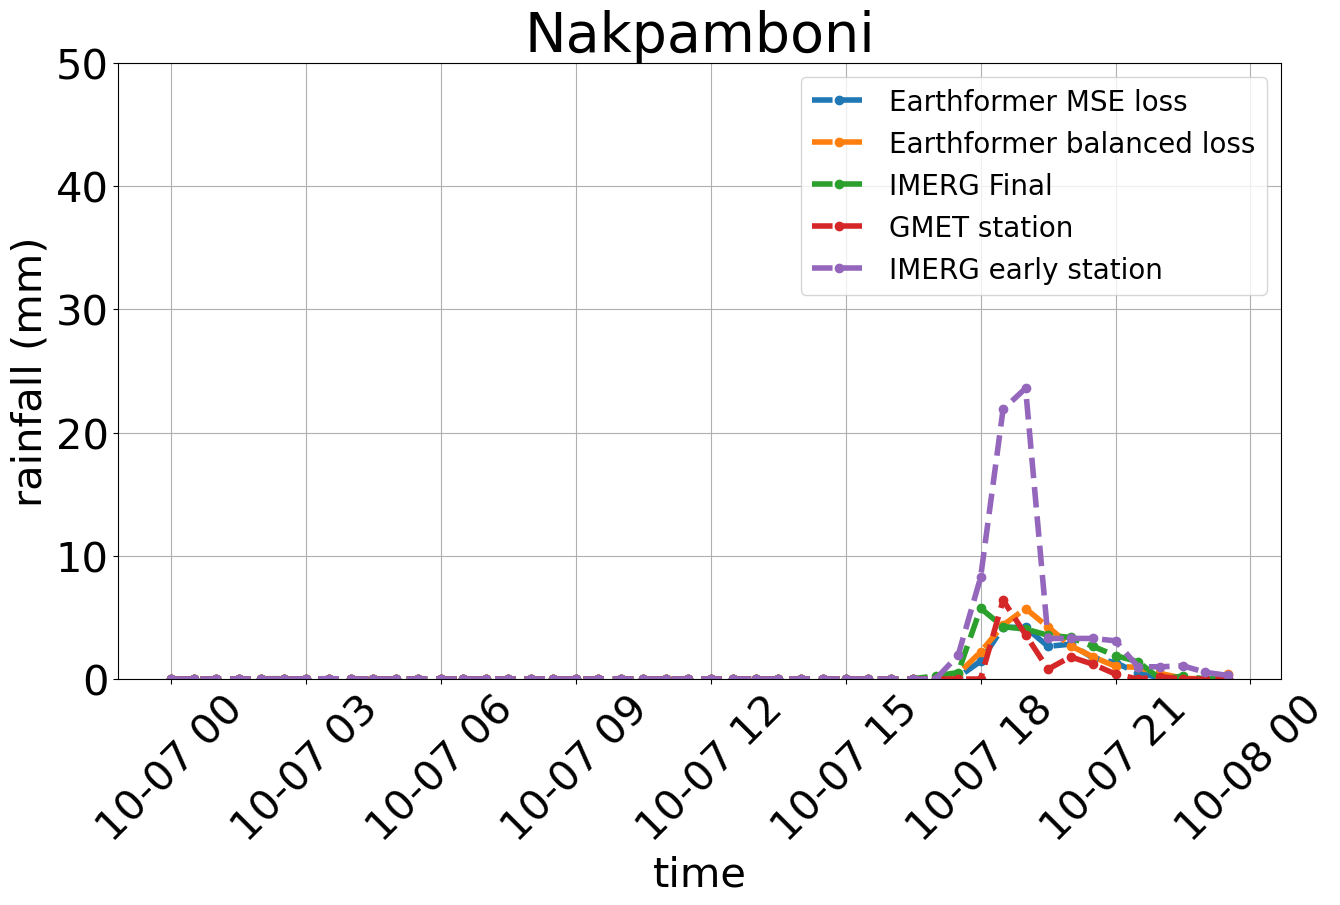

In [13]:
time_period = '2022-10-07'
station = 'Nakpamboni'
resample = '30min'

linewidth = 4

plt.figure(figsize = (15, 8))
df_resampled = df_pred.resample(resample).sum()
df_resampled_balanced = df_pred_balanced.resample(resample).sum()
df_target_resampled = df_target.resample(resample).sum()
df_early_resampled = df_early.resample(resample).sum()



df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample(resample).sum()

plt.plot(df_resampled[station].loc[time_period], linestyle = '--', marker = 'o', linewidth = linewidth, label = f'Earthformer MSE loss')
plt.plot(df_resampled_balanced[station].loc[time_period], linestyle = '--', marker = 'o', linewidth = linewidth, label = f'Earthformer balanced loss')
plt.plot(df_target_resampled[station].loc[time_period], linestyle = '--', marker = 'o', linewidth = linewidth, label = f'IMERG Final')
plt.plot(df_gmet_resampled.loc[time_period], linestyle = '--', marker = 'o', linewidth = linewidth, label = f'GMET station')
plt.plot(df_early_resampled[station].loc[time_period], linestyle = '--', marker = 'o', linewidth = linewidth, label = f'IMERG early station')
plt.xlabel('time', fontsize = 30)
plt.ylabel('rainfall (mm)', fontsize = 30)
plt.xticks(fontsize=30, rotation=45)
plt.yticks(fontsize=30)
plt.legend(fontsize = 20)
plt.title(f'{station}', fontsize = 40)
plt.ylim(0, 50)
plt.grid()
#plt.savefig(f'{station}_{time_period}_timeseries.png', bbox_inches='tight', dpi=300)

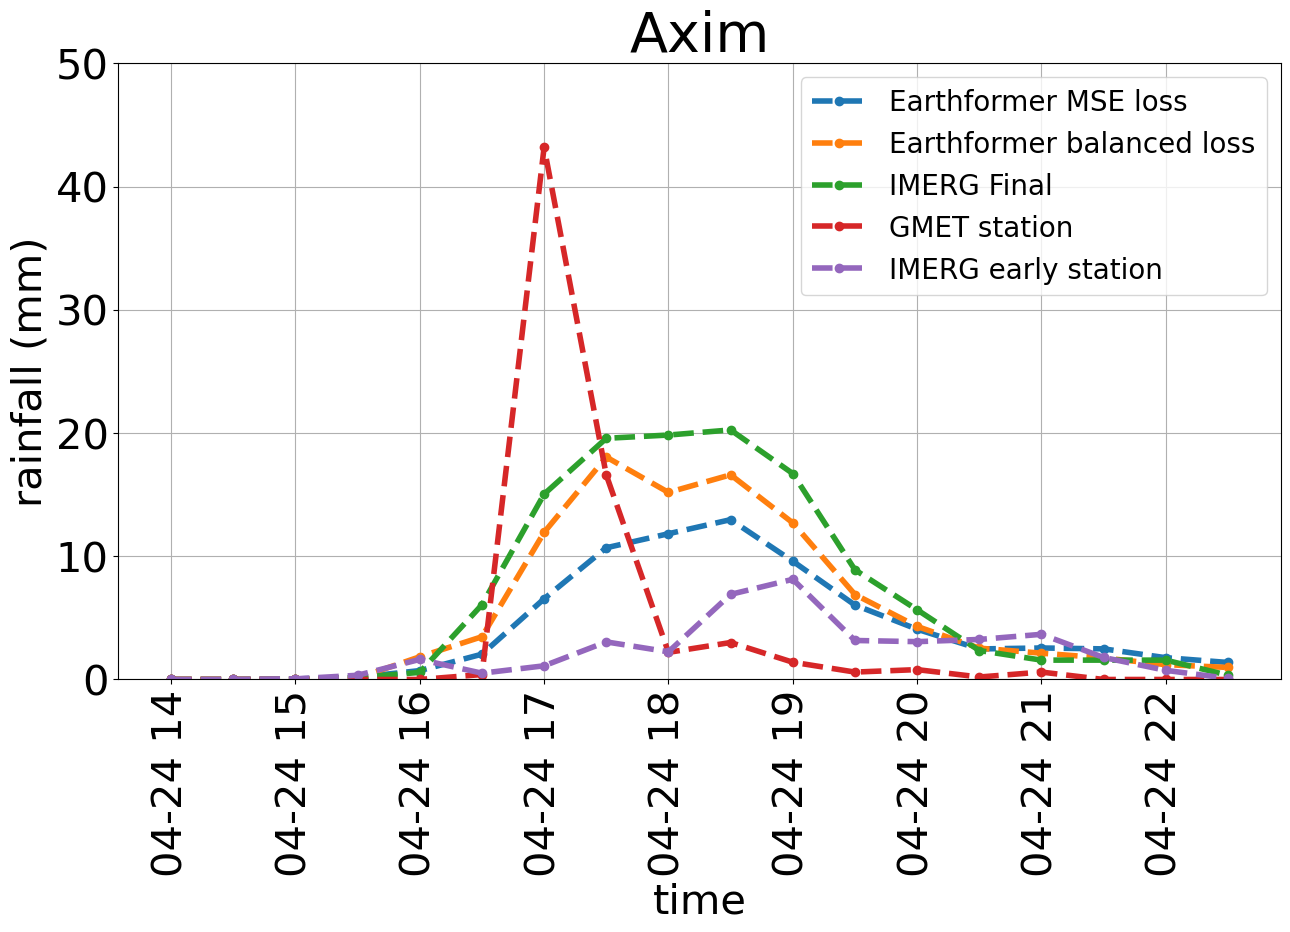

In [42]:
# df_pred = pd.read_csv('df_output_gmet_2022.csv', index_col = 0, parse_dates = True)
# df_pred[df_pred <= 0.02] = 0
# df_target = pd.read_csv('df_target_gmet_2022.csv', index_col = 0, parse_dates = True)
# df_target[df_target <= 0.02] = 0
# df_early = pd.read_csv('imerg_early_precip.csv', index_col = 0, parse_dates = True)

start_date = '2022-04-24 14:00:00'
end_date = '2022-04-24 22:30:00'
station = 'Axim'
resample = '30min'

linewidth = 4

plt.figure(figsize = (15, 8))
df_resampled = df_pred.resample(resample).sum()
df_resampled_balanced = df_pred_balanced.resample(resample).sum()
df_target_resampled = df_target.resample(resample).sum()
df_early_resampled = df_early.resample(resample).sum()



df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample(resample).sum()

plt.plot(df_resampled[station].loc[start_date:end_date], linestyle = '--', marker = 'o', linewidth = linewidth, label = f'Earthformer MSE loss')
plt.plot(df_resampled_balanced[station].loc[start_date:end_date], linestyle = '--', marker = 'o', linewidth = linewidth, label = f'Earthformer balanced loss')
plt.plot(df_target_resampled[station].loc[start_date:end_date], linestyle = '--', marker = 'o', linewidth = linewidth, label = f'IMERG Final')
plt.plot(df_gmet_resampled.loc[start_date:end_date], linestyle = '--', marker = 'o', linewidth = linewidth, label = f'GMET station')
plt.plot(df_early_resampled[station].loc[start_date:end_date], linestyle = '--', marker = 'o', linewidth = linewidth, label = f'IMERG early station')
plt.xlabel('time', fontsize = 30)
plt.ylabel('rainfall (mm)', fontsize = 30)
plt.xticks(fontsize=30, rotation=90)
plt.yticks(fontsize=30)
plt.legend(fontsize = 20)
plt.title(f'{station}', fontsize = 40)
plt.ylim(0, 50)
plt.grid()
plt.savefig(f'{station}_{start_date[0:10]}_timeseries.png', bbox_inches='tight', dpi=300)

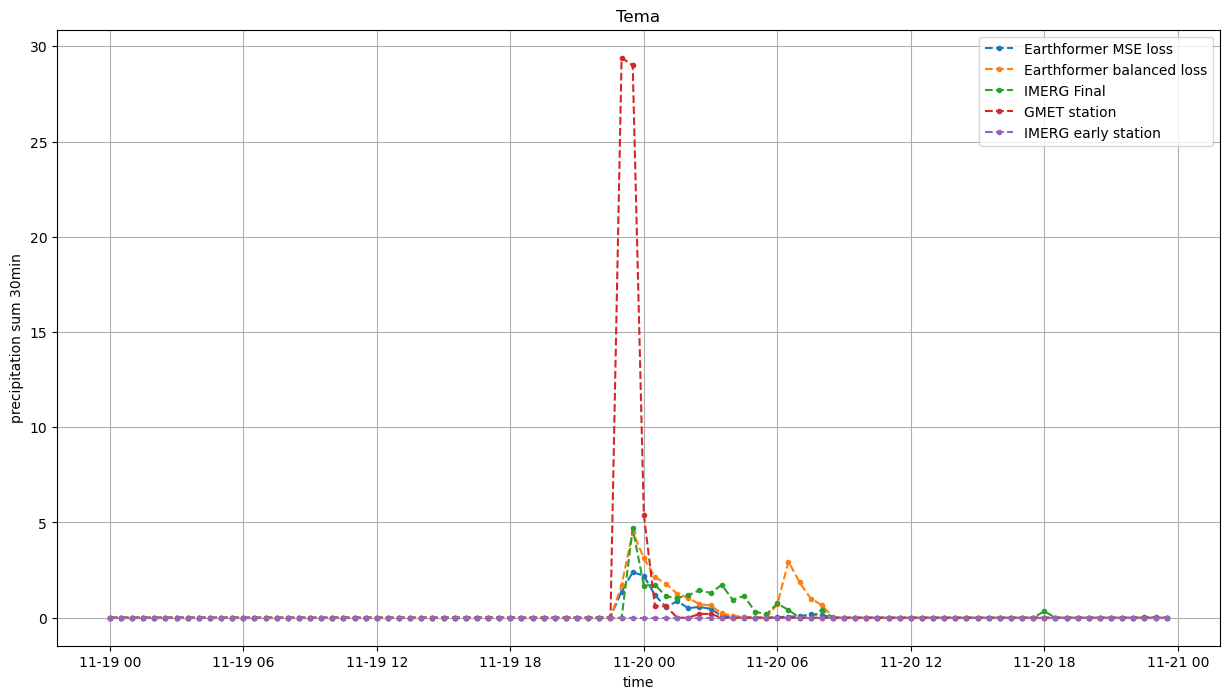

In [14]:
start_date = '2022-11-19'
end_date = '2022-11-20'
station = 'Tema'
resample = '30min'

plt.figure(figsize = (15, 8))
df_resampled = df_pred.resample(resample).sum()
df_resampled_balanced = df_pred_balanced.resample(resample).sum()
df_target_resampled = df_target.resample(resample).sum()
df_early_resampled = df_early.resample(resample).sum()



df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample(resample).sum()

plt.plot(df_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer MSE loss')
plt.plot(df_resampled_balanced[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer balanced loss')
plt.plot(df_target_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG Final')
plt.plot(df_gmet_resampled.loc[start_date:end_date], linestyle = '--', marker = '.', label = f'GMET station')
plt.plot(df_early_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG early station')
plt.xlabel('time')
plt.ylabel(f'precipitation sum {resample}')
plt.legend()
plt.title(f'{station}')
plt.grid()
plt.savefig(f'{station}_{start_date}_{end_date}_timeseries.png')

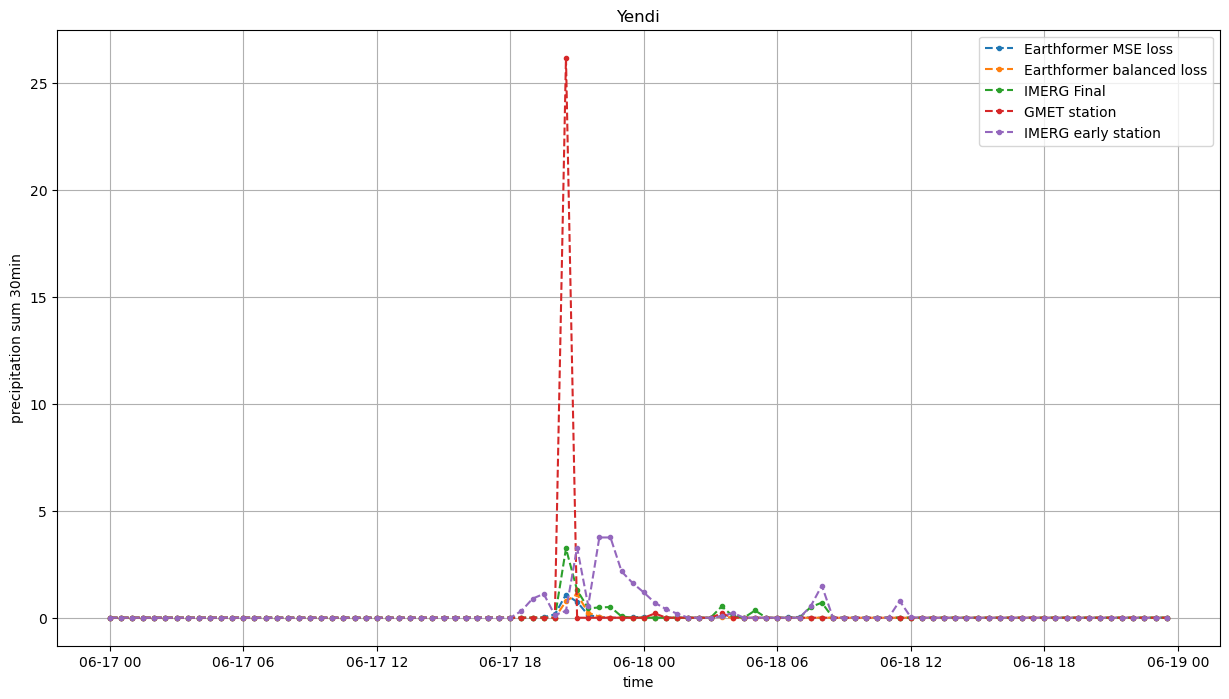

In [15]:
start_date = '2022-06-17'
end_date = '2022-06-18'
station = 'Yendi'
resample = '30min'

plt.figure(figsize = (15, 8))
df_resampled = df_pred.resample(resample).sum()
df_resampled_balanced = df_pred_balanced.resample(resample).sum()
df_target_resampled = df_target.resample(resample).sum()
df_early_resampled = df_early.resample(resample).sum()



df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample(resample).sum()

plt.plot(df_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer MSE loss')
plt.plot(df_resampled_balanced[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer balanced loss')
plt.plot(df_target_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG Final')
plt.plot(df_gmet_resampled.loc[start_date:end_date], linestyle = '--', marker = '.', label = f'GMET station')
plt.plot(df_early_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG early station')
plt.xlabel('time')
plt.ylabel(f'precipitation sum {resample}')
plt.legend()
plt.title(f'{station}')
plt.grid()
plt.savefig(f'{station}_{start_date}_{end_date}_timeseries.png')

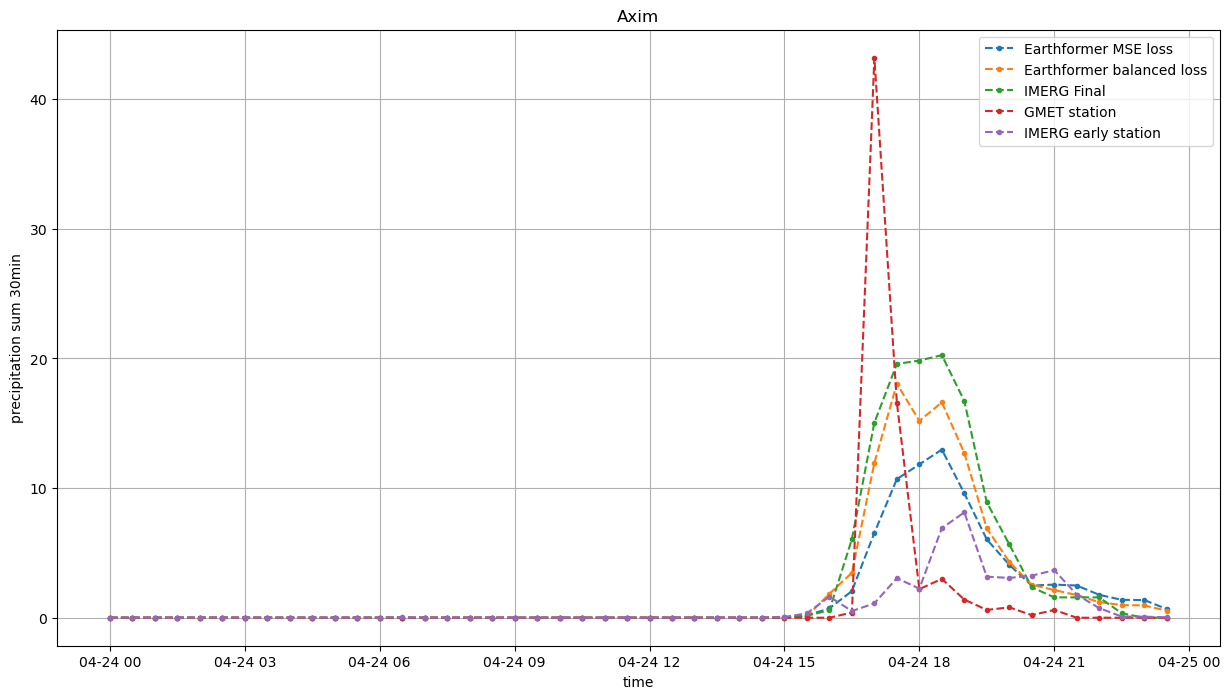

In [19]:
start_date = '2022-04-24'
end_date = '2022-04-24'
station = 'Axim'
resample = '30min'

plt.figure(figsize = (15, 8))
df_resampled = df_pred.resample(resample).sum()
df_resampled_balanced = df_pred_balanced.resample(resample).sum()
df_target_resampled = df_target.resample(resample).sum()
df_early_resampled = df_early.resample(resample).sum()



df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample(resample).sum()

plt.plot(df_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer MSE loss')
plt.plot(df_resampled_balanced[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer balanced loss')
plt.plot(df_target_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG Final')
plt.plot(df_gmet_resampled.loc[start_date:end_date], linestyle = '--', marker = '.', label = f'GMET station')
plt.plot(df_early_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG early station')
plt.xlabel('time')
plt.ylabel(f'precipitation sum {resample}')
plt.legend()
plt.title(f'{station}')
plt.grid()
#plt.savefig(f'{station}_{start_date}_{end_date}_timeseries.png')

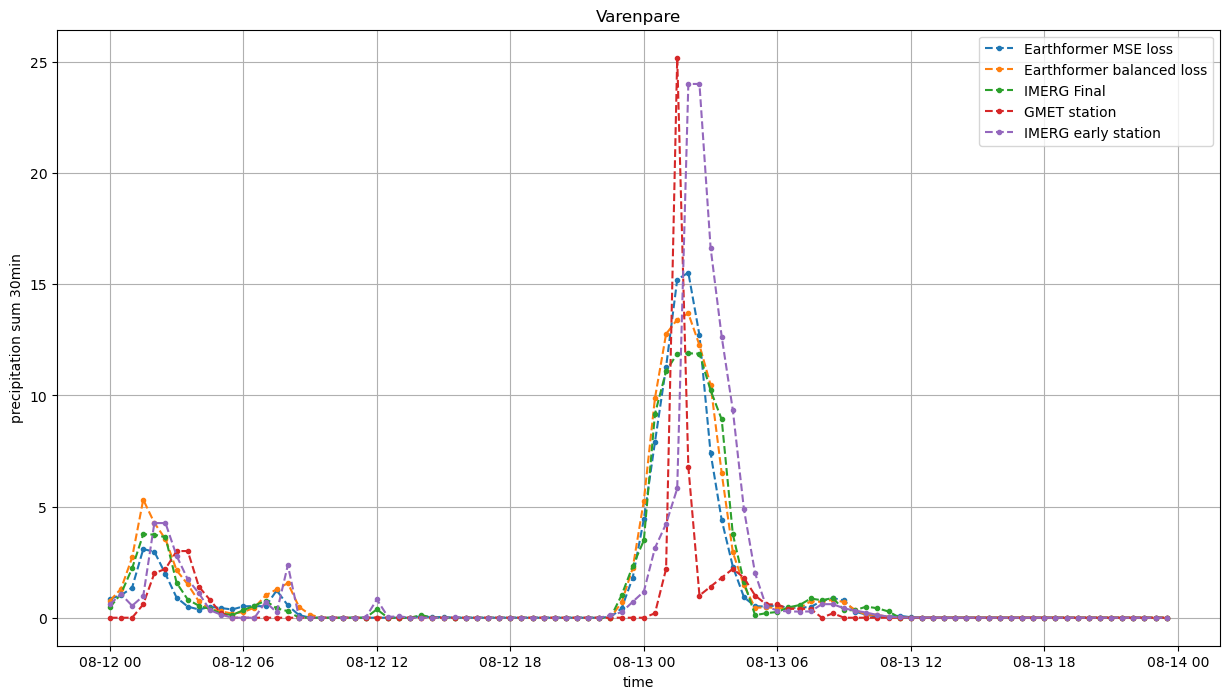

In [17]:
start_date = '2022-08-12'
end_date = '2022-08-13'
station = 'Varenpare'
resample = '30min'

plt.figure(figsize = (15, 8))
df_resampled = df_pred.resample(resample).sum()
df_resampled_balanced = df_pred_balanced.resample(resample).sum()
df_target_resampled = df_target.resample(resample).sum()
df_early_resampled = df_early.resample(resample).sum()



df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample(resample).sum()

plt.plot(df_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer MSE loss')
plt.plot(df_resampled_balanced[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer balanced loss')
plt.plot(df_target_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG Final')
plt.plot(df_gmet_resampled.loc[start_date:end_date], linestyle = '--', marker = '.', label = f'GMET station')
plt.plot(df_early_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG early station')
plt.xlabel('time')
plt.ylabel(f'precipitation sum {resample}')
plt.legend()
plt.title(f'{station}')
plt.grid()
plt.savefig(f'{station}_{start_date}_{end_date}_timeseries.png')

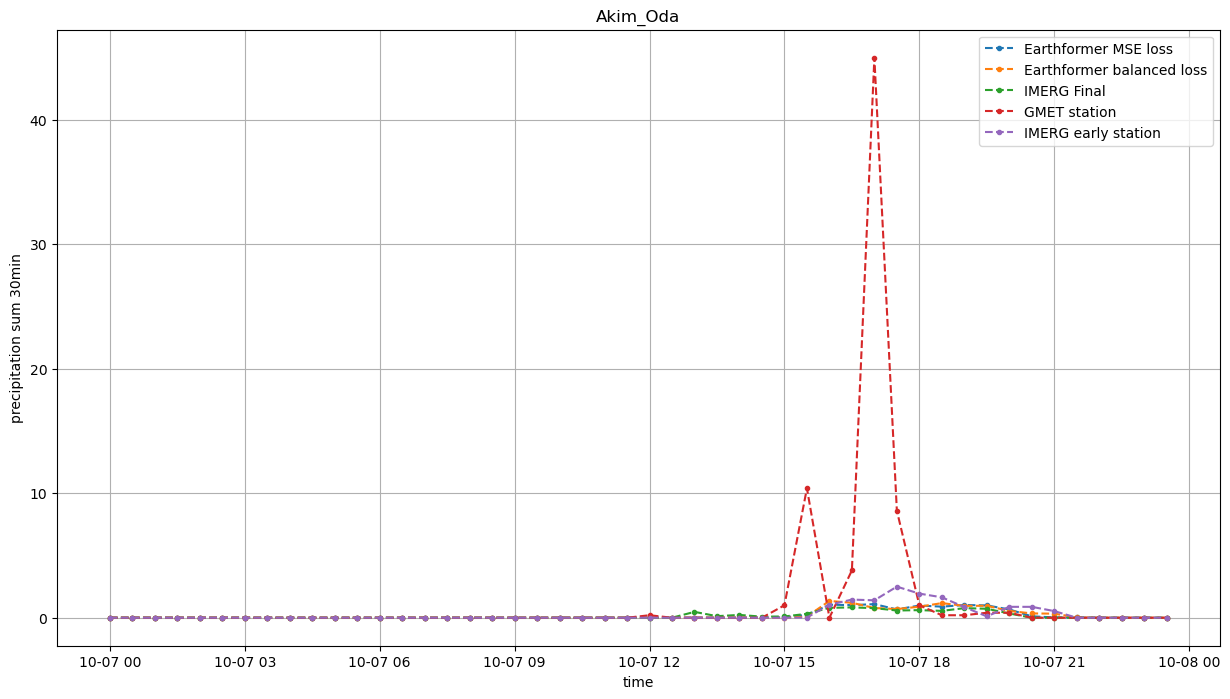

In [25]:
start_date = '2022-10-07 '
end_date = '2022-10-07'
station = 'Akim_Oda'
resample = '30min'

plt.figure(figsize = (15, 8))
df_resampled = df_pred.resample(resample).sum()
df_resampled_balanced = df_pred_balanced.resample(resample).sum()
df_target_resampled = df_target.resample(resample).sum()
df_early_resampled = df_early.resample(resample).sum()



df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample(resample).sum()

plt.plot(df_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer MSE loss')
plt.plot(df_resampled_balanced[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer balanced loss')
plt.plot(df_target_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG Final')
plt.plot(df_gmet_resampled.loc[start_date:end_date], linestyle = '--', marker = '.', label = f'GMET station')
plt.plot(df_early_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG early station')
plt.xlabel('time')
plt.ylabel(f'precipitation sum {resample}')
plt.legend()
plt.title(f'{station}')
plt.grid()
plt.savefig(f'{station}_{start_date}_{end_date}_timeseries.png')

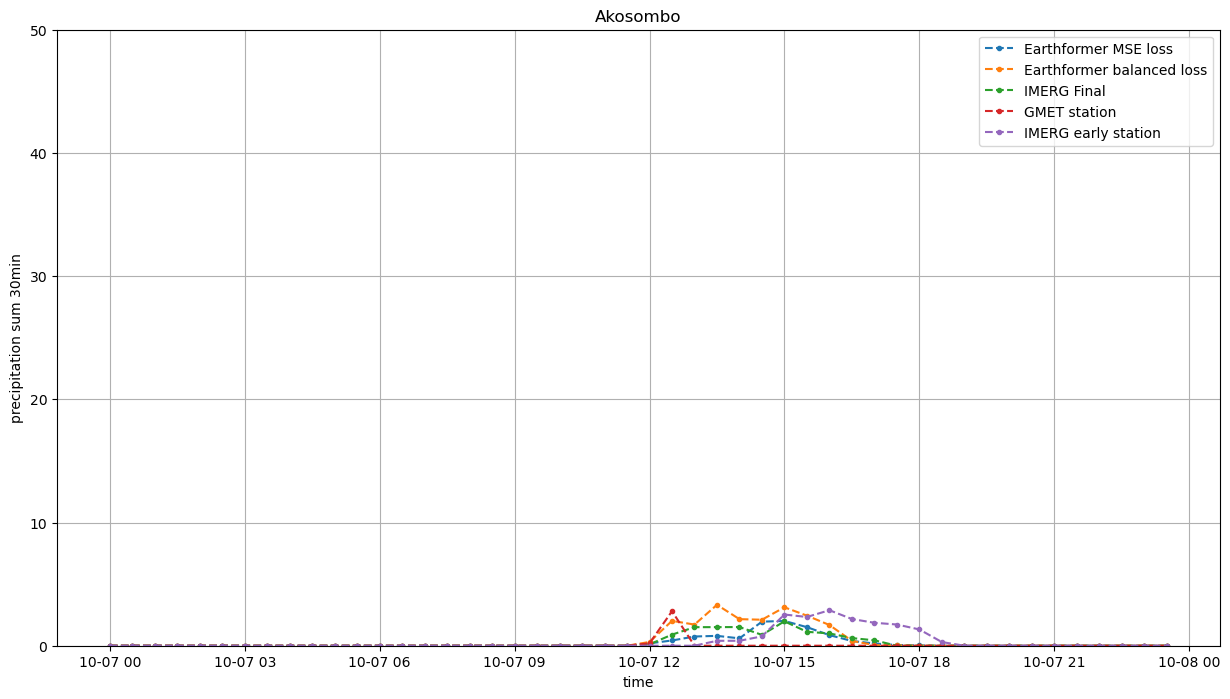

In [29]:
start_date = '2022-10-07 '
end_date = '2022-10-07'
station = 'Akosombo'
resample = '30min'

plt.figure(figsize = (15, 8))
df_resampled = df_pred.resample(resample).sum()
df_resampled_balanced = df_pred_balanced.resample(resample).sum()
df_target_resampled = df_target.resample(resample).sum()
df_early_resampled = df_early.resample(resample).sum()



df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample(resample).sum()

plt.plot(df_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer MSE loss')
plt.plot(df_resampled_balanced[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer balanced loss')
plt.plot(df_target_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG Final')
plt.plot(df_gmet_resampled.loc[start_date:end_date], linestyle = '--', marker = '.', label = f'GMET station')
plt.plot(df_early_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG early station')
plt.xlabel('time')
plt.ylim(0, 50)
plt.ylabel(f'precipitation sum {resample}')
plt.legend()
plt.title(f'{station}')
plt.grid()
plt.savefig(f'{station}_{start_date}_{end_date}_timeseries.png')

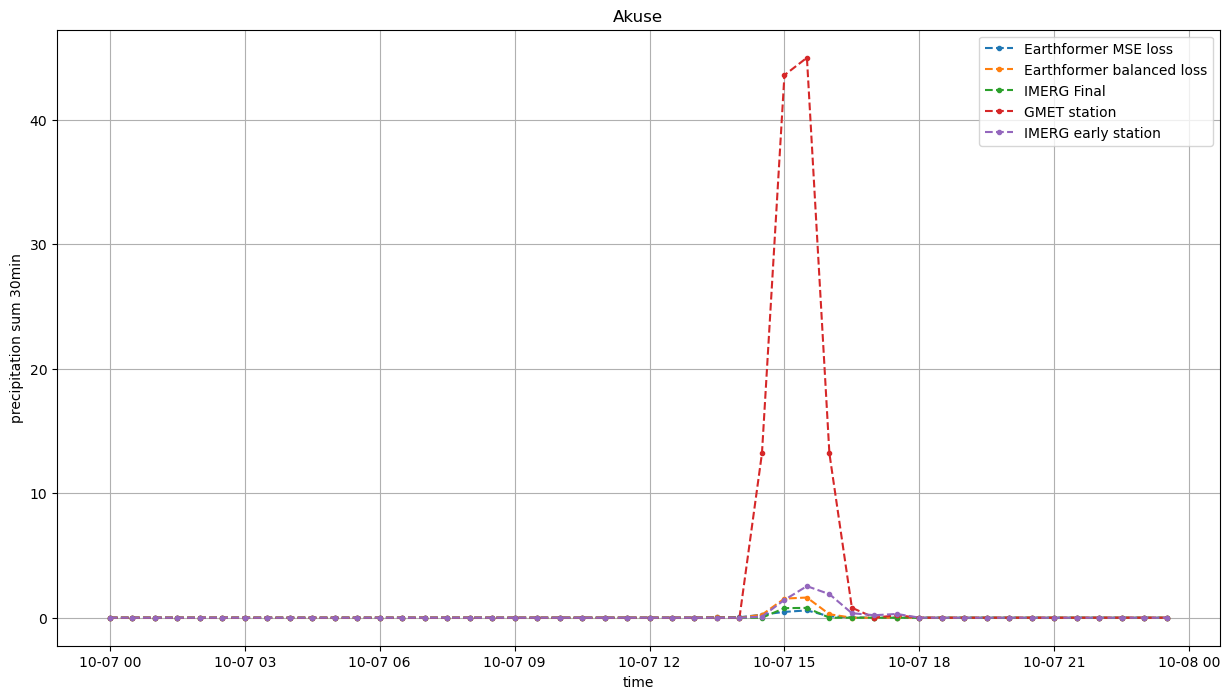

In [26]:
start_date = '2022-10-07'
end_date = '2022-10-07'
station = 'Akuse'
resample = '30min'

plt.figure(figsize = (15, 8))
df_resampled = df_pred.resample(resample).sum()
df_resampled_balanced = df_pred_balanced.resample(resample).sum()
df_target_resampled = df_target.resample(resample).sum()
df_early_resampled = df_early.resample(resample).sum()



df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample(resample).sum()

plt.plot(df_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer MSE loss')
plt.plot(df_resampled_balanced[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer balanced loss')
plt.plot(df_target_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG Final')
plt.plot(df_gmet_resampled.loc[start_date:end_date], linestyle = '--', marker = '.', label = f'GMET station')
plt.plot(df_early_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG early station')
plt.xlabel('time')
plt.ylabel(f'precipitation sum {resample}')
plt.legend()
plt.title(f'{station}')
plt.grid()
plt.savefig(f'{station}_{start_date}_{end_date}_timeseries.png')

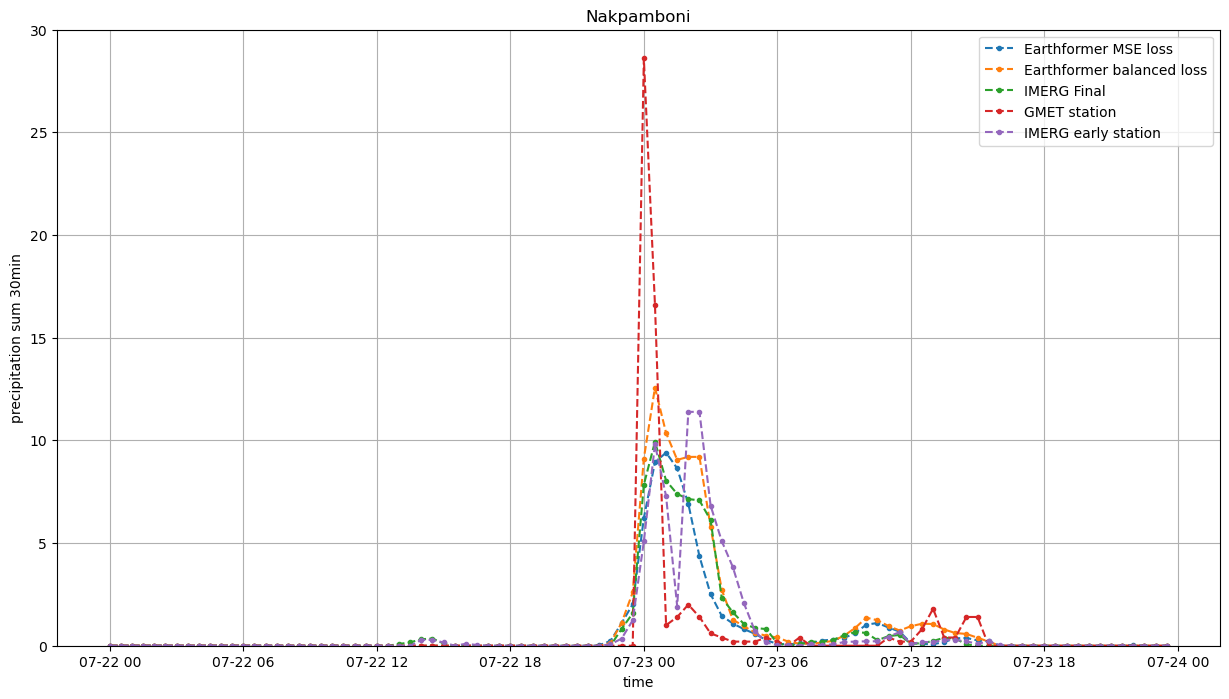

In [52]:
start_date = '2022-07-22'
end_date = '2022-07-23'
station = 'Nakpamboni'
resample = '30min'
plt.figure(figsize = (15, 8))
df_resampled = df_pred.resample(resample).sum()
df_resampled_balanced = df_pred_balanced.resample(resample).sum()
df_target_resampled = df_target.resample(resample).sum()
df_early_resampled = df_early.resample(resample).sum()



df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample(resample).sum()

plt.plot(df_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer MSE loss')
plt.plot(df_resampled_balanced[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer balanced loss')
plt.plot(df_target_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG Final')
plt.plot(df_gmet_resampled.loc[start_date:end_date], linestyle = '--', marker = '.', label = f'GMET station')
plt.plot(df_early_resampled[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG early station')
plt.xlabel('time')
plt.ylim(0, 30)
plt.ylabel(f'precipitation sum {resample}')
plt.legend()
plt.title(f'{station}')
plt.grid()
plt.savefig(f'{station}_{start_date}_{end_date}_timeseries.png')

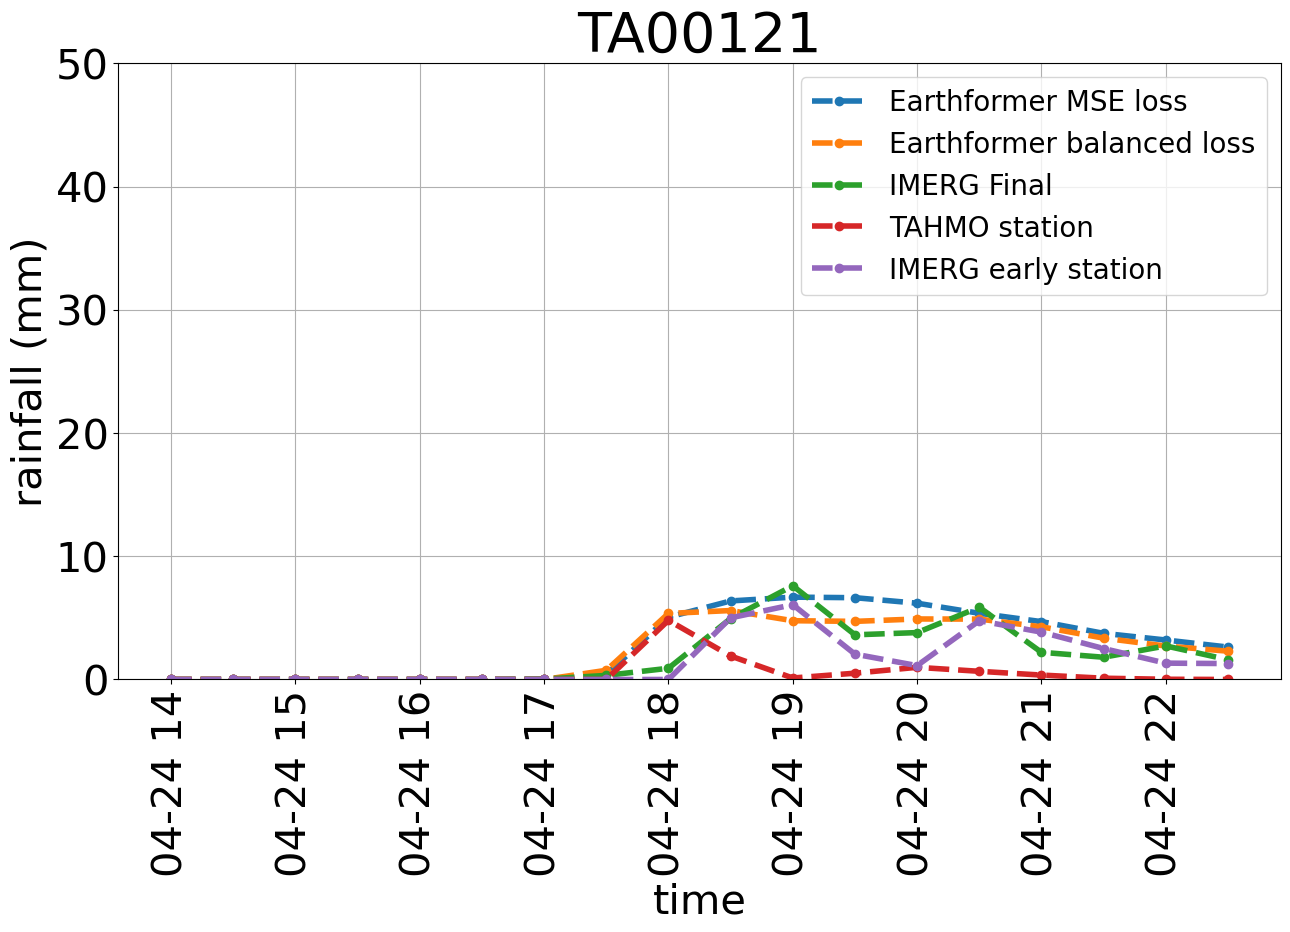

In [41]:
start_date = '2022-04-24 14:00:00'
end_date = '2022-04-24 22:30:00'
station = 'TA00121'
resample = '30min'

linewidth = 4

plt.figure(figsize = (15, 8))
df_resampled_tahmo = df_pred_tahmo.resample(resample).sum()
df_resampled_balanced_tahmo = df_pred_balanced_tahmo.resample(resample).sum()
df_target_resampled_tahmo = df_target_tahmo.resample(resample).sum()
df_early_resampled_tahmo = df_early_tahmo.resample(resample).sum()



df_tahmo = station_data_tahmo_dict[station]
df_tahmo = df_tahmo.apply(pd.to_numeric, errors='coerce')
df_tahmo_resampled = df_tahmo.resample(resample).sum()

plt.plot(df_resampled_tahmo[station].loc[start_date:end_date], linestyle = '--', marker = 'o', linewidth = linewidth, label = f'Earthformer MSE loss')
plt.plot(df_resampled_balanced_tahmo[station].loc[start_date:end_date], linestyle = '--', marker = 'o', linewidth = linewidth, label = f'Earthformer balanced loss')
plt.plot(df_target_resampled_tahmo[station].loc[start_date:end_date], linestyle = '--', marker = 'o', linewidth = linewidth, label = f'IMERG Final')
plt.plot(df_tahmo_resampled.loc[start_date:end_date], linestyle = '--', marker = 'o', linewidth = linewidth, label = f'TAHMO station')
plt.plot(df_early_resampled_tahmo[station].loc[start_date:end_date], linestyle = '--', marker = 'o', linewidth = linewidth, label = f'IMERG early station')
plt.xlabel('time', fontsize = 30)
plt.ylabel('rainfall (mm)', fontsize = 30)
plt.xticks(fontsize=30, rotation=90)
plt.yticks(fontsize=30)
plt.legend(fontsize = 20)
plt.title(f'{station}', fontsize = 40)
plt.ylim(0, 50)
plt.grid()
plt.savefig(f'{station}_{start_date[0:10]}_timeseries.png', bbox_inches='tight', dpi=300)

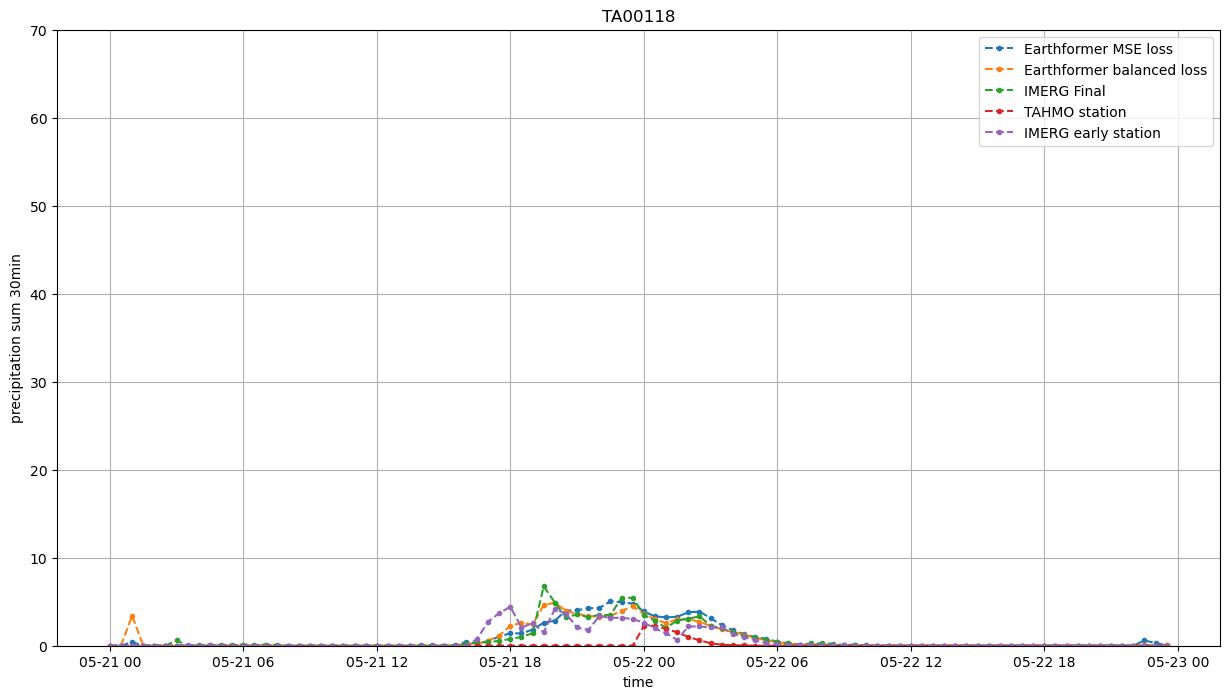

In [41]:
start_date = '2022-05-21'
end_date = '2022-05-22'
station = 'TA00118'
resample = '30min'

plt.figure(figsize = (15, 8))
df_resampled_tahmo = df_pred_tahmo.resample(resample).sum()
df_resampled_balanced_tahmo = df_pred_balanced_tahmo.resample(resample).sum()
df_target_resampled_tahmo = df_target_tahmo.resample(resample).sum()
df_early_resampled_tahmo = df_early_tahmo.resample(resample).sum()



df_tahmo = station_data_tahmo_dict[station]
df_tahmo = df_tahmo.apply(pd.to_numeric, errors='coerce')
df_tahmo_resampled = df_tahmo.resample(resample).sum()

plt.plot(df_resampled_tahmo[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer MSE loss')
plt.plot(df_resampled_balanced_tahmo[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'Earthformer balanced loss')
plt.plot(df_target_resampled_tahmo[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG Final')
plt.plot(df_tahmo_resampled.loc[start_date:end_date], linestyle = '--', marker = '.', label = f'TAHMO station')
plt.plot(df_early_resampled_tahmo[station].loc[start_date:end_date], linestyle = '--', marker = '.', label = f'IMERG early station')
plt.xlabel('time')
plt.ylim(0, 70)
plt.ylabel(f'precipitation sum {resample}')
plt.legend()
plt.title(f'{station}')
plt.grid()
plt.savefig(f'{station}_{start_date}_{end_date}_timeseries.png')

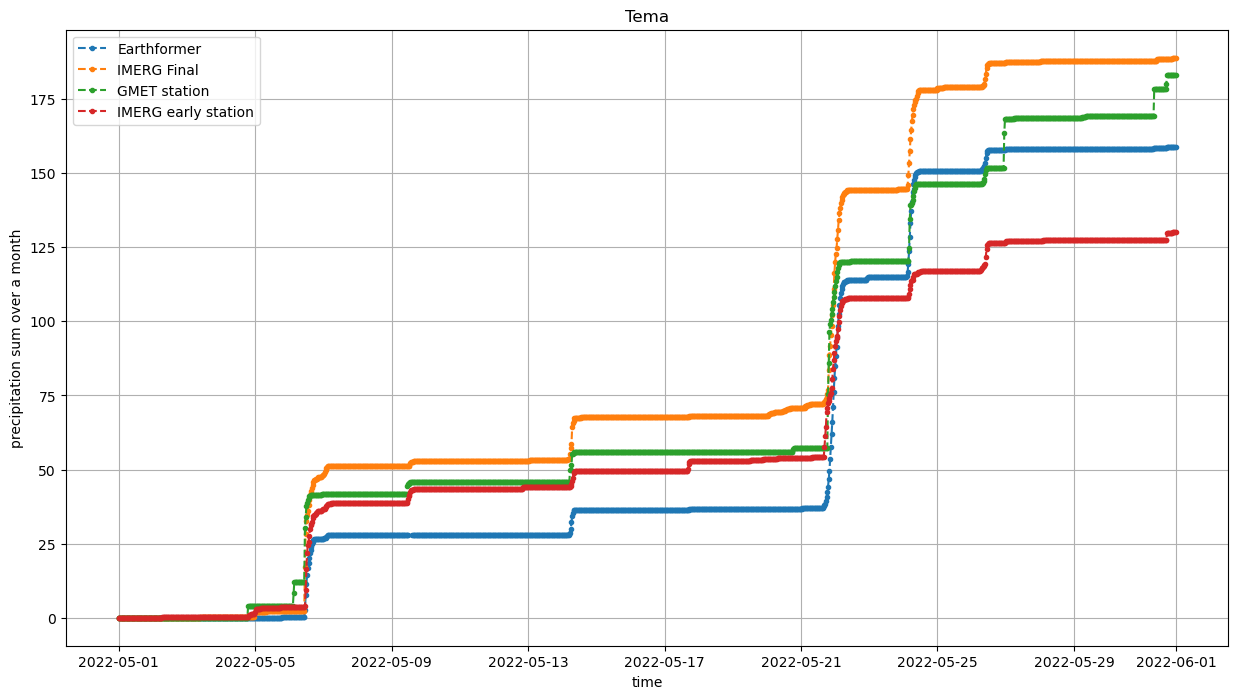

In [9]:
time_period = '2022-05'
station = 'Tema'

plt.figure(figsize = (15, 8))
df_resampled = df_pred.loc[time_period].cumsum()
df_target_resampled = df_target.loc[time_period].cumsum()
df_early_resampled = df_early.loc[time_period].cumsum()



df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.loc[time_period].cumsum()

plt.plot(df_resampled[station].loc[time_period], linestyle = '--', marker = '.', label = f'Earthformer')
plt.plot(df_target_resampled[station].loc[time_period], linestyle = '--', marker = '.', label = f'IMERG Final')
plt.plot(df_gmet_resampled.loc[time_period], linestyle = '--', marker = '.', label = f'GMET station')
plt.plot(df_early_resampled[station].loc[time_period], linestyle = '--', marker = '.', label = f'IMERG early station')
plt.xlabel('time')
plt.ylabel('precipitation sum over a month')
plt.legend()
plt.title(f'{station}')
plt.grid()